### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:
3 > np.inf

False

In [9]:
1 < np.inf

True

### Utils

In [2]:
def show_image(img, size=(40, 6), title=None):
    plt.figure(figsize=size)
    plt.axis('off')
    
    if title is not None:
        plt.title(title)
    
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.show()
    
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img // 255
    return img

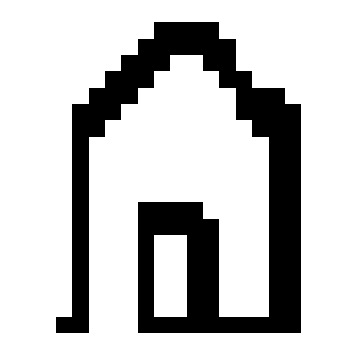

In [3]:
img = read_image('images/house3.png')
show_image(img)

In [ ]:
# Moves
'''
8 1 2
7 0 3
6 5 4
'''
moves = [
    (0, 0), (-1, 0), (-1, 1),
    (0, 1), (1, 1), (1, 0),
    (1, -1), (0, -1), (-1, -1),
]

# Costs of rotations.
rotation_costs = [0, 1, 2, 3, 4, 3, 2, 1]

# Meta
non_empty_pixels = (img == 0).sum()
bound_row = img.shape[0] - 1
bound_col = img.shape[1] - 1

# Hyperparameters
candidate_size = int(non_empty_pixels * 1.25) # size of a candidate solution
pop_size = 4096 # candidate count per iteration
mut_prob = 0.05 # probability of mutation
mut_ratio = 0.1 # size of mutation
mut_ratio_decay = 0.0005 # decay of mutation ratio per generation
mut_size = int(candidate_size * mut_ratio)
max_gen = 1024 # maximum generation
cross_point = 2 # split points of crossover
gen_keep = int(pop_size * 0.25) # number of best candidates to keep
gen_renew = pop_size - gen_keep

# Configurations
log_interval = 1

print(f'non_empty_pixels={non_empty_pixels}')
print(f'candidate_size={candidate_size}')
print(f'mut_size={mut_size}')
print(f'gen_keep={gen_keep}')
print(f'gen_renew={gen_renew}')

In [ ]:
# Create number random generator
rng = np.random.default_rng()

# Create initial population.
population = np.random.randint(0, 9, (pop_size, candidate_size))

# Keep track of last gen's best.
fit_of_gen_best = np.inf
gen_of_gen_best = 0

# Iterate generations.
for gen in range(max_gen):    
    fitnesses = []
    
    # Keep best solution to show.
    best_fitness = np.inf
    best_solution = None
    
    # Calculate fitness of each candidate
    for candidate in population:
        # Fitness of candidate
        ft_rotate_cost = 0
        ft_overlap_rate = 0
        ft_spread_loss = 0
        ft_paint_loss = 0
        
        # Create solution of this candidate.
        solution = np.ones(img.shape)
        
        # Start point for solution.
        prev_mov_dir = -1
        row = img.shape[0] - 1 
        col = 0
        for direction in candidate:
            # Paint pixel if in bound.
            if (0 <= row <= bound_row) and (0 <= col <= bound_col):
                solution[row][col] = 0
            
            # Calculate rotation cost.
            if prev_mov_dir != -1:
                rotate_costs = np.roll(rotation_costs, prev_mov_dir - 1)
                step_rotate_cost = rotate_costs[direction - 1]
                ft_rotate_cost = step_rotate_cost / 4
            prev_mov_dir = direction
            
            # Findout next position.
            move = moves[direction]
            next_row = row + move[0]
            next_col = col + move[1]
            if (0 <= next_row <= bound_row) and (0 <= next_col <= bound_col):
                row = next_row
                col = next_col
        
        # Normalize rotation cost of candidate.
        ft_rotate_cost /= candidate_size
        
        # Calculate overlap rate fitness.
        overlap = (np.logical_or(solution, img) == False).sum()
        ft_overlap_rate = 1 - (overlap / non_empty_pixels)
        
        # Calculate spread loss fitness.
        ft_spread_loss = (non_empty_pixels - overlap) / non_empty_pixels
        
        # Calculate paint loss fitness. 
        non_empy_solution = (solution == 0).sum()
        ft_paint_loss = (candidate_size - non_empy_solution) / candidate_size
        
        # Calculate total fitness.
        fitness = 0
        fitness += 0.2 * ft_rotate_cost
        fitness += 1.6 * ft_overlap_rate
        fitness += 0.8 * ft_spread_loss
        fitness += 0.4 * ft_paint_loss
        fitnesses.append(fitness)
        
        # Keep if best candidate.
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = solution
    
    # Order the candidates by their fitness.
    fitnesses = np.array(fitnesses)
    orders = fitnesses.argsort()
    fitnesses = fitnesses[orders]
    population = population[orders] 
    
    # Calculate weight distribution of candidates.
    ft_probs = 1 / fitnesses
    ft_probs = ft_probs / ft_probs.sum()

    # Create 2n pairs by weighted random (fitness)
    pairs_len = pop_size * 2
    pairs = population[np.random.choice(population.shape[0], pairs_len, p=ft_probs)]
    
    # Crossover and Mutate to create new candidates.
    new_population = []
    for i in range(0, pairs_len, 2):
        # Crossover 
        a = pairs[i]
        b = pairs[i+1]
        # Generate random split points.
        splits = rng.choice(candidate_size, size=cross_point, replace=False)
        splits.sort()
        # Split parents.
        a = np.split(a, splits, axis=0)
        b = np.split(b, splits, axis=0)
        pair = [a, b]
        # Pick parts randomly from parents.
        picks = np.random.randint(0, 2, cross_point + 1)
        new_candidate = [x for i, p in enumerate(picks) for x in pair[p][i]]
        
        # Mutate Candidate
        if np.random.rand() < mut_prob:
            mut_ratio *= (1 - mut_ratio_decay) ** gen
            mut_size = int(candidate_size * mut_ratio)
            new_sequence = np.random.randint(0, 9, mut_size)
            insert_point = np.random.randint(0, candidate_size - mut_size - 1, 1)[0]
            new_candidate[insert_point:insert_point+mut_size] = new_sequence
        
        # Add candidate to new population.
        new_population.append(new_candidate)
        
    # Keep some of current generation and fill rest with new.
    population[gen_keep:] = new_population[:gen_renew]
    
    # Keep stats of generation's best
    if fitnesses[0] < fit_of_gen_best:
        fit_of_gen_best = fitnesses[0]
        gen_of_gen_best = gen
        
    # Show the best candidate.
    if gen % log_interval == 0:
        print(f'Gen#{gen} ft={fitnesses[0]} bestgen={gen_of_gen_best}')
        show_image(best_solution)